In [1]:
# running ViViT with 3D MNIST dataset 

# Code source of implementation of ViViT: https://github.com/rishikksh20/ViViT-pytorch
# Only model 2 from ViViT: A Video Transformer is implemented 

In [1]:
import torch
from torch import nn, einsum
import torch.nn.functional as F
from einops import rearrange, repeat
from einops.layers.torch import Rearrange
from module import Attention, PreNorm, FeedForward
from scipy import ndimage
import numpy as np

from MNIST_3D_data import MNIST_3D_Growing, MNIST_3D_Random_Rotation, MNIST_3D_Gaussian_Noise, scipy_clipped_zoom_3d
from vivit import ViViT 

### Loading 3DMnist data

In [2]:
from torchvision import transforms, utils
transforms = transforms.Compose([
    MNIST_3D_Random_Rotation(max_angle = 15),
    MNIST_3D_Gaussian_Noise(mean = 0, var = 0.000001)
])

In [3]:
config = {
    'num_train_data': 1000,
    'num_test_data' : 200,
    'class_names' : ['non', 
                   'slow_g',
                   'steady_g',
                   'fast_g',
                   'slow_s',
                   'steady_s',
                   'fast_s'],
    'class_growth_rates' : {'non' : 1,
                          'slow_g' :1.1,
                          'steady_g':1.2,
                          'fast_g': 1.3,
                          'slow_s': 0.9,
                          'steady_s': 0.8,
                          'fast_s': 0.75}

}

In [4]:
save_path = './dataset/3D_MNIST_vanilla.npz'
training_data = MNIST_3D_Growing(save_path, scipy_clipped_zoom_3d, 
                                 config['num_train_data'],  
                                 train = True,
                                 transforms = transforms,
                                 class_names = config['class_names'],  
                                 class_growth_factors = config['class_growth_rates']
                                 
                                )
testing_data = MNIST_3D_Growing(save_path, scipy_clipped_zoom_3d, 
                                 config['num_test_data'],
                                 train = False,
                                transforms = transforms,
                                class_names = config['class_names'],  
                                 class_growth_factors = config['class_growth_rates']
                                
                                )

In [5]:
training_generator = torch.utils.data.DataLoader(training_data, batch_size=16)
testing_generator = torch.utils.data.DataLoader(testing_data, batch_size=16)

In [14]:
# train_features, train_labels = next(iter(training_generator))
# train_features.shape
# batch size = 16, time steps = 3, 28 x 28 x 28 image

torch.Size([16, 3, 28, 1, 28, 28])

### Initializing model

In [8]:
# documenting the ViViT class from https://github.com/rishikksh20/ViViT-pytorch

# def __init__(self, image_size, patch_size, num_classes, num_frames, dim = 192, depth = 4, heads = 3, pool = 'cls', in_channels = 3, dim_head = 64, dropout = 0.,
#                 emb_dropout = 0., scale_dim = 4, ):
        
# image size: height = width of image 
# patch size: size of the little patches where an image will be divided into 
# num classes
# num frames 
# dim: dimension of the input zl (rasterized image patch) 
# depth: number of attention layers
# heads: number of heads in an attention layer 
# pool: pool type must be either cls (cls token) or mean (mean pooling)
# in_channels: number of channels of input
# dim_head: dimensions of the heads

vivit_input = {
    'image_size': 28,
    'patch_size': 14, 
    'num_classes': len(config["class_names"]),
    'num_frames': 3, 
    'in_channels': 1
}

model = ViViT(image_size=vivit_input["image_size"], 
              patch_size=vivit_input["patch_size"], 
              num_classes=vivit_input["num_classes"], 
              num_frames=vivit_input["num_frames"], 
              in_channels=vivit_input["in_channels"])




In [13]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    device = torch.device('cuda:0')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    print('cpu')
    device = torch.device('cpu')

cpu


In [9]:
# source: https://github.com/bdrad/project-conv-meleon/blob/3DMNIST/ConvLSTM_3D_training_loop.ipynb

def validate(model, data_loader):
        model.eval()
        correct = 0
        with torch.no_grad():
            for features, labels in data_loader:
                features = features.to(torch.float)
                
                # reshaping input into the model to match the dimensions
                # num frame x channels x height x width 
                features = torch.unsqueeze(torch.squeeze(features), 2)
                
                labels = labels.to(torch.long)
                features = features.to(device)
                labels = labels.to(device)
                outputs = torch.argmax(model(features), dim=1)
                correct += int(torch.sum(outputs==labels))
        print(f'Validation Accuracy: {correct/(len(data_loader) * data_loader.batch_size) * 100:.3f}%')
        return correct/(len(data_loader) * data_loader.batch_size) * 100

def save_model(model, savepath):
    torch.save(model.state_dict(), savepath)

### Training loop

In [10]:
#hyperparameters
epochs=10
learning_rate = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_log = {
    "validation_accuracy": [], 
    "training_loss": []
}

In [14]:
import time
for epoch in range(epochs):
    
    start = time.time()
    
    model.train()
    current_train_loss = 0
    length = 0
    for x, y in training_generator:
        optimizer.zero_grad()
        
        # reshape data to fit into model 
        # x should have the dimensions batch x num frame x channels x height x width x depth
        x = torch.squeeze(x)
        x = torch.unsqueeze(x, 2)
        
        x = x.to(device).type(torch.float32)
        y = y.to(device).long()
        
        output = model(x)
        loss = criterion(output, y)
        current_train_loss += float(loss.item())
        length += x.shape[0]
        # ===================backward====================
        loss.backward()
        optimizer.step()
    # ===================log========================
    current_train_loss = current_train_loss / length
    
    print("Epoch {} training loss: {}".format(epoch+1, current_train_loss))
    val_acc = validate(model, testing_generator)
    model_log['validation_accuracy'].append(val_acc)
    model_log['training_loss'].append(current_train_loss)
    
    end = time.time()
    print("time elapsed: {} seconds".format(end-start))

Epoch 1 training loss: 0.10251504302024841
Validation Accuracy: 49.038%
time elapsed: 12.703698873519897 seconds
Epoch 2 training loss: 0.056313783466815946
Validation Accuracy: 59.615%
time elapsed: 12.746339082717896 seconds
Epoch 3 training loss: 0.03853002327680588
Validation Accuracy: 63.942%
time elapsed: 12.772907972335815 seconds
Epoch 4 training loss: 0.02755959266424179
Validation Accuracy: 74.038%
time elapsed: 12.5641188621521 seconds
Epoch 5 training loss: 0.02396791535615921
Validation Accuracy: 79.808%
time elapsed: 12.45219111442566 seconds
Epoch 6 training loss: 0.016171586778014897
Validation Accuracy: 79.327%
time elapsed: 12.444457054138184 seconds
Epoch 7 training loss: 0.009526586091145874
Validation Accuracy: 83.173%
time elapsed: 12.448561906814575 seconds
Epoch 8 training loss: 0.00755807566922158
Validation Accuracy: 74.038%
time elapsed: 12.440860986709595 seconds
Epoch 9 training loss: 0.006996331023052335
Validation Accuracy: 82.692%
time elapsed: 12.444482

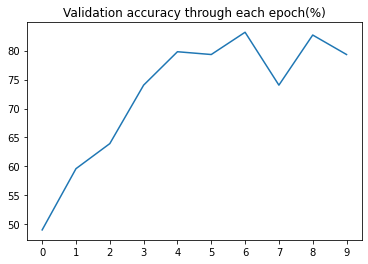

In [15]:
import matplotlib.pyplot as plt 

plt.title("Validation accuracy through each epoch(%)")
plt.xticks(np.arange(epochs))
plt.plot(model_log['validation_accuracy'], label="validation accuracy");

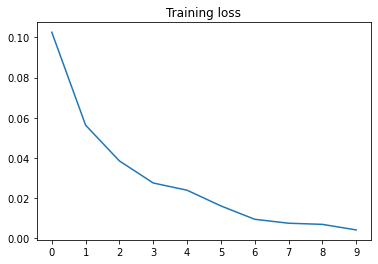

In [16]:
plt.title("Training loss")
plt.xticks(np.arange(epochs))
plt.plot(model_log['training_loss'], label="training loss");